In [1]:
import tarfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
tar_file_path = '/content/drive/My Drive/aclImdb_v1.tar.gz'

In [4]:
# Unzip the file to a directory
with tarfile.open(tar_file_path, 'r') as tar_ref:
    tar_ref.extractall('/content/aclImdb')

In [5]:
data_dir = '/content/aclImdb/aclImdb'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [6]:
# Load data
def load_data_from_directory(directory):
    texts = []
    labels = []
    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(directory, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)
    return texts, labels

train_texts, train_labels = load_data_from_directory(train_dir)
test_texts, test_labels = load_data_from_directory(test_dir)

In [7]:
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
print(train_df.head())


                                                text  label
0  To be clear from the get go, 'The Bagman' is v...      0
1  When people ask me whats the worst movie I've ...      0
2  If you haven't seen the gong show TV series th...      0
3  Beyond a shadow of a doubt Mysterious Planet i...      0
4  Before I begin, I want to briefly say that thi...      0


In [8]:
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})
print(test_df.head())

                                                text  label
0  Help, I've ended up in cinema hell! What a com...      0
1  Watched this piece ONDEMAND because the descri...      0
2  Whenever someone tries to tell me that they th...      0
3  Wow! That James Purefoy looks exactly like Tho...      0
4  Film starts off great in 1872 with a violent, ...      0


In [9]:
# Check label distribution
print("Training data label distribution:")
print(f"Positive reviews: {np.sum(train_labels)}")
print(f"Negative reviews: {len(train_labels) - np.sum(train_labels)}")

print("Testing data label distribution:")
print(f"Positive reviews: {np.sum(test_labels)}")
print(f"Negative reviews: {len(test_labels) - np.sum(test_labels)}")

Training data label distribution:
Positive reviews: 12500
Negative reviews: 12500
Testing data label distribution:
Positive reviews: 12500
Negative reviews: 12500


In [10]:
vocab_path = os.path.join(data_dir, 'imdb.vocab')
ratings_path = os.path.join(data_dir, 'imdbEr.txt')

# Read vocabulary
with open(vocab_path, 'r', encoding='utf-8') as f:
    vocab = f.read().splitlines()

In [11]:
# Read expected ratings
expected_ratings = np.loadtxt(ratings_path)

In [12]:
# Combine vocab and ratings into a DataFrame for better understanding
vocab_df = pd.DataFrame({'word': vocab, 'expected_rating': expected_ratings})
print(vocab_df.head())

  word  expected_rating
0  the         0.049097
1  and         0.201364
2    a         0.033395
3   of         0.099838
4   to        -0.079021


In [13]:
# Create a Tokenizer instance
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_texts)

In [14]:
# Parameters
max_features = 20000
max_len = 250

In [15]:
# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_texts)


In [16]:
# text to sequences of integers
x_train = tokenizer.texts_to_sequences(train_texts)
x_test = tokenizer.texts_to_sequences(test_texts)

In [17]:
# Pad sequences to ensure uniform input length
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [18]:
# labels to numpy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [19]:
# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)

Training data shape: (20000, 250)
Validation data shape: (5000, 250)
Test data shape: (25000, 250)


In [20]:
#Word2Vec model
sentences = [text.split() for text in train_texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [21]:
# embedding matrix
word_index = tokenizer.word_index
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), embedding_dim)

In [22]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(units=128, activation='tanh', dropout=0.3, recurrent_dropout=0.0)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
save_dir = '/content/drive/My Drive/Sentiment_analysis_model'
os.makedirs(save_dir, exist_ok=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(os.path.join(save_dir, 'sentiment_model.keras'), save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping and model checkpointing
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
625/625 [==============================] - 22s 25ms/step - loss: 0.5608 - accuracy: 0.7157 - val_loss: 0.4972 - val_accuracy: 0.7786
Epoch 2/10
625/625 [==============================] - 13s 20ms/step - loss: 0.4255 - accuracy: 0.8097 - val_loss: 0.3583 - val_accuracy: 0.8422
Epoch 3/10
625/625 [==============================] - 13s 20ms/step - loss: 0.3748 - accuracy: 0.8373 - val_loss: 0.3441 - val_accuracy: 0.8516
Epoch 4/10
625/625 [==============================] - 14s 22ms/step - loss: 0.3396 - accuracy: 0.8591 - val_loss: 0.3265 - val_accuracy: 0.8582
Epoch 5/10
625/625 [==============================] - 13s 21ms/step - loss: 0.3182 - accuracy: 0.8703 - val_loss: 0.3193 - val_accuracy: 0.8738
Epoch 6/10
625/625 [==============================] - 12s 19ms/step - loss: 0.2995 - accuracy: 0.8784 - val_loss: 0.3306 - val_accuracy: 0.8674
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 0.2848 - accuracy: 0.8872 - val_loss: 0.3023 - val_accuracy:

In [24]:
# Evaluating the model on test data
score = model.evaluate(x_test, y_test)
test_loss, test_accuracy = score[0], score[1]
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

#training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

if train_accuracy - val_accuracy > 0.05:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")

782/782 [==============================] - 7s 9ms/step - loss: 0.2857 - accuracy: 0.8872
Test Loss: 0.2856931984424591
Test Accuracy: 0.8871999979019165
Training Accuracy: 0.9053500294685364
Validation Accuracy: 0.8804000020027161
The model is not overfitting.


782/782 [==============================] - 6s 7ms/step


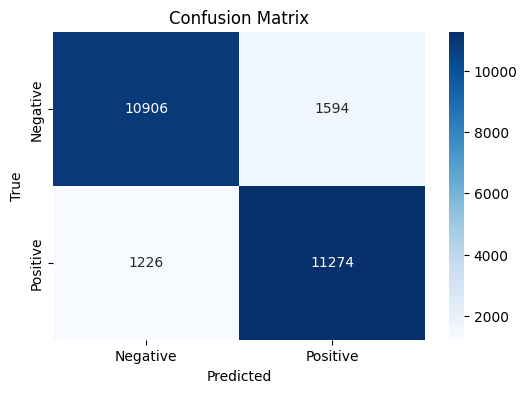

Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.87      0.89     12500
    Positive       0.88      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [25]:
#confusion matrix and classification report
def evaluate_model_performance(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    cr = classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive'])
    print("Classification Report:\n", cr)

evaluate_model_performance(model, x_test, y_test)


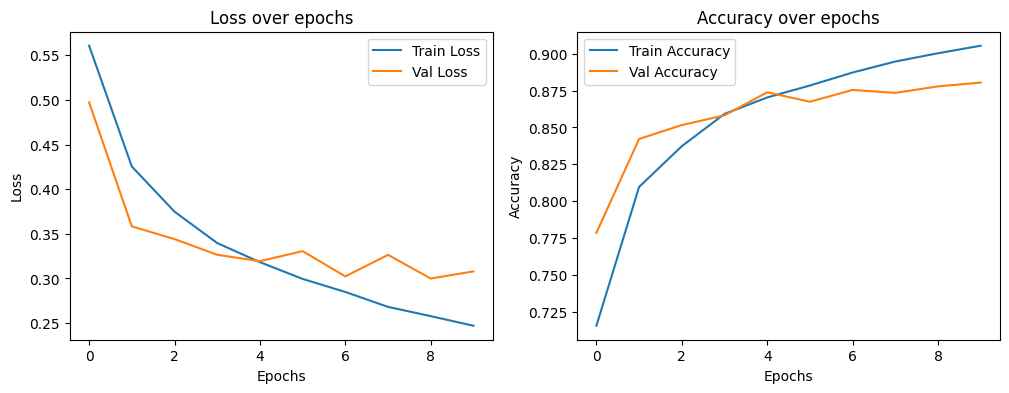

In [26]:
# Plot training and validation loss and accuracy
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Val Loss')
    axs[0].set_title('Loss over epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axs[1].set_title('Accuracy over epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

plot_training_history(history)


In [28]:
def sample_predictions(model, x_test, test_texts, y_test, num_samples=5):
    y_pred = model.predict(x_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    indices = np.random.choice(len(x_test), num_samples, replace=False)

    # DataFrame to display the results
    samples = []
    for i in indices:
        samples.append({
            'Review': test_texts[i],
            'True Label': 'Positive' if y_test[i] == 1 else 'Negative',
            'Predicted Label': 'Positive' if y_pred_classes[i] == 1 else 'Negative',
            'Confidence': y_pred[i][0]
        })

    df_samples = pd.DataFrame(samples)

    def highlight_misclassifications(row):
        return ['background-color: #FFAAAA' if row['True Label'] != row['Predicted Label'] else '' for _ in row]

    styled_df = df_samples.style.apply(highlight_misclassifications, axis=1)
    display(styled_df)

sample_predictions(model, x_test, test_texts, y_test, num_samples=5)


782/782 [==============================] - 7s 8ms/step


,Review,True Label,Predicted Label,Confidence
0,"(Contains spoilers)Russia in the 13th century. The opening shot shows the relics of the last invasion: moldering uniforms, human skulls and a horse's skeleton. Prince Alexander Nevsky (Nikolai Cherkasov) chased the swedish army away and impressed the mongol ruler to such a degree that he proposes to promote him to the rank of captain. But Nevsky replies: ""Die in your homeland but don't leave it"". He intents to fish, build ships and trade. But he warns of a more dangerous enemy: Nearer, meaner and no possibility to buy oneself out: Germany. Their objective is Novgorod. They have already reached Pskov: Mothers and daughters suffer for their fathers and sons. The marauding occupation forces distribute the looty. Rich merchants want to purchase their liberty (always a place for some anti-capitalist p. r.), but the ""common people"" are ready to fight. They want Alexander as their leader. Pskov is burned to the ground. The teutonic knights feel invincible and have just a smug smile for the russian women who witness helplessly how their fathers and sons are butchered. Babies are thrown in the fire while high dignitaries of the church look on and remain idle. In Novgorod: Olga Danilovna has two admirers: rich and staid Gavrilo and tall and jolly Vasili. She promises to marry the most valiant. Vasili calls on Alexander Nevsky in Perejaslav. The prince decides not to wait for the attack but to strike at once. Even women put on a chain armor...The invaders want to bait the ""russian bear"", but Nevsky's stratagem stands the test: Lake Peipus is his war zone : His men know the territory but the germans, who are heavier, will break through the ice...Open your eyes and watch the most impressive battle scenes ever filmed. It's not just the multitude of extras (Who were, I think, pressed in this patriotic exercise), but Eisenstein's masterful management of such a large number of individuals: he displaces divisions like pieces on a chess board and nearly every shot resembles the composition of a painting by Rembrandt or Rubens (Including horses in phantastic outfits). Russia in winter looks intimidating in itself, but Eisenstein's visual imagination is hors concours. Heaps of corpses are plunged in cosmic light under an endless horizon. At nightfall, Olga and other women search with torches for survivors. A devoted falcon sits on his master's dead body while a crow waits for the right moment to pick out the eyes of the deceased. Eisenstein's direction and Prokofiev's score make ALEXANDER NEVSKY the ""Rolls Royce"" among propaganda films. Nevsky is, of course Stalin's alter ego, and the russians are tall, good-looking, heroic, and they have a perfect hairdo. The germans are bearded savages and look like members of the Ku-Klux-Klan. The actor who plays Vasili gives a one-man-four-characters performance: first wavering, then heroic, youthful lover and comic relief. Cherkasov's main duty is to look heroic. At the end, Nevsky-Stalin displays his generosity: He pardons the ""little soldiers"" and barters the knights for soap. Only a bearded killer and a traitorous cleric are turned over to the mob. He does not forget a final warning: Who comes with the sword will die by the sword...He kept his promise. 10/10",Positive,Positive,0.988610
1,"I was very excited to see a documentary on one of my favorite Italian directors. D'Amato has dabbled in everything from Horror, post-apocalyptic to hardcore Porn. He has touched upon genius a couple of times with films like Buio Omega and Emmanuelle & The Last Cannibals. This documentary is a lenghty and informative guide to the films of D'Amato. He is interviewed throughout with English subtitles rolling across the bottom of the screen. The excerpts from his films are narrated by a narrator (with english subtitles). The documentary proved extra interesting when it analyzed the often censored ""Emmanuelle In America"". Here D'amato explaines the faked ""snuff"" sc